In [1]:
import os
import sys
sys.path.append('/fefs/aswg/workspace/mitsunari.takahashi/Soft/common')

from LowLevelAnalysis import ConfigItem, ImageExtractorConfig, TailcutConfig, LowLevelAnalysis
from LowLevelData import Data, DL0Data, DL0DataSingleFile, DL1Data, DL1DataSingleFile

import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
import math

from math import ceil
import numpy as np
import numpy.ma as ma
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
import tables
from collections import OrderedDict

import astropy.units as u
from astropy.io import fits
from astropy.table import Table, vstack
import datetime

from traitlets.config.loader import Config
from ctapipe_io_lst import LSTEventSource
from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay
from ctapipe.image import hillas_parameters
from ctapipe.containers import EventType

from lstchain.io.config import read_configuration_file
import lstchain.reco.utils as utils
from lstchain.reco import r0_to_dl1
from lstchain.io.io import dl1_images_lstcam_key, dl1_params_tel_mon_ped_key, dl1_params_tel_mon_cal_key, dl1_params_lstcam_key, dl1_params_src_dep_lstcam_key

from ctapipe.utils import get_dataset_path
from ctapipe.io import EventSource
from ctapipe.io.eventseeker import EventSeeker
#import astropy.units as u
#from copy import deepcopy

from scipy.stats import binned_statistic

import pSLUM

In [2]:
from logging import getLogger,StreamHandler,DEBUG,INFO,WARNING,ERROR,CRITICAL

##### Logger #####
logger = getLogger(__name__)
handler = StreamHandler()
loglevel = 'INFO'
handler.setLevel(loglevel)
logger.setLevel(loglevel)
logger.addHandler(handler)

In [3]:
from lstchain import __version__ as lstchain_version
logger.info(lstchain_version)

0.8.5.dev6+g50b0a41.d20220126


In [4]:
# Matplotlib setup
plt.rcParams["font.size"] = 13

LINE_STYLES = ["solid", "dashed", "dashdot", "dotted"]
MARKER_STYLES = ['o', 's', 'x', '+', 'D', 'X', 'p', 'd', '<', '>', '^', 'v', 'H']

#plt.xkcd()

In [5]:
# Replace OUTPUT_DIR_PATH by your directory
OUTPUT_DIR_PATH = Path('/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses')
if not OUTPUT_DIR_PATH.exists():
    os.makedirs(OUTPUT_DIR_PATH)


# Config of Tailcut

In [7]:
tailcut_configs = [TailcutConfig({"picture_thresh":8, "boundary_thresh":4, \
                                "sigma":2.5, "keep_isolated_pixels":"false", \
                                "min_number_picture_neighbors":2, \
                                "use_only_main_island":"false", \
                                "delta_time":2},
                                abbreviation='pth8_bth4'),
                   TailcutConfig({"picture_thresh":6, "boundary_thresh":3, \
                                "sigma":2.5, "keep_isolated_pixels":"false", \
                                "min_number_picture_neighbors":2, \
                                "use_only_main_island":"false", \
                                "delta_time":2},
                                abbreviation='pth6_bth3'),
                   TailcutConfig({"picture_thresh":5, "boundary_thresh":3, \
                                "sigma":2.5, "keep_isolated_pixels":"false", \
                                "min_number_picture_neighbors":2, \
                                "use_only_main_island":"false", \
                                "delta_time":2},
                                abbreviation='pth5_bth3'),
                   TailcutConfig({"picture_thresh":5, "boundary_thresh":2, \
                                "sigma":2.5, "keep_isolated_pixels":"false", \
                                "min_number_picture_neighbors":2, \
                                "use_only_main_island":"false", \
                                "delta_time":2},
                                abbreviation='pth5_bth2')]

# Config of ImageExtracter

## List of confugurations to evaluate  

In [8]:
image_extractor_configs = []
real_image_extractor_configs = []

# TwoPassWindowSum
for core_threshold in (5,6,7):
    image_extractor_configs.append(ImageExtractorConfig('TwoPassWindowSum', 
                                                        {'core_threshold':core_threshold, 
                                                         'disable_second_pass':'false',
                                                         'apply_integration_correction':'true'}
                                                       , abbreviation='TPWS_c{c}'.format(c=core_threshold)))
    real_image_extractor_configs.append(ImageExtractorConfig('TwoPassWindowSum', 
                                                        {'core_threshold':core_threshold, 
                                                         'disable_second_pass':'false',
                                                         'apply_integration_correction':'false'}
                                                       , abbreviation='TPWS_c{c}'.format(c=core_threshold)))

In [9]:
# Write the config files down     
lowlevel_configs= []
real_lowlevel_configs= []
for tailcut_config in tailcut_configs:
    for ie in image_extractor_configs:
        lowlevel_configs.append(LowLevelAnalysis(configs=[ie, tailcut_config], 
                                             output_dir_path=OUTPUT_DIR_PATH, 
                                             config_dir_path=OUTPUT_DIR_PATH,
                                            abbreviation='_'.join([ie.abbreviation, tailcut_config.abbreviation])))
        real_lowlevel_configs.append(LowLevelAnalysis(configs=[ie, tailcut_config], 
                                             output_dir_path=OUTPUT_DIR_PATH, 
                                             config_dir_path=OUTPUT_DIR_PATH,
                                            abbreviation='_'.join([ie.abbreviation, tailcut_config.abbreviation])))
for c in lowlevel_configs:    
    c.write_configfile()
for c in real_lowlevel_configs:    
    c.write_configfile()    

# Shower event selection

In [10]:
EMIN = 0 *u.GeV
EMAX = 100 *u.GeV

In [11]:
tel_id = 1 #LST-1
allowed_tels = {tel_id}

In [12]:
REQUSTED_PARAMETERS = ["event_type",
                        'intensity', 
                        'log_intensity', 
                        'length', 
                        'width', 
                        'wl', 
                        'skewness',
                        'kurtosis', 
                        'leakage_intensity_width_2', 
                        'n_islands',
                        'intercept',
                        'n_pixels',
                        'time_gradient']

In [13]:
HILLASES_OF_INTEREST = ['intensity', 
                        'log_intensity', 
                        'length', 
                        'width', 
                        'wl', 
                        'skewness',
                        'kurtosis', 
                        'leakage_intensity_width_2', 
                        'n_islands',
                        'n_pixels',
                        'time_gradient']

# Real data

In [14]:
real_runs = [3948, 4699, 2181, 4859]
real_dates = {3948: '20210310', 4699: '20210511', 2181: '20200710', 4859: '20210531'}
real_subruns = {3948: range(0, 1), 4699: range(0, 1), 2181: range(0, 1), 4859: range(0, 1)}
calibration_runs = {3948:3945, 4699: 4696, 2181: 2175, 4859: 4851}
drs4_pedestal_runs = {3948: 3944, 4699: 4695, 2181: 2174, 4859: 4850}
time_calibration_runs = {3948: 3945, 4699: 4696, 2181: 2175, 4859: 4851}
#enf_sys_dates = {3948: '20210321', 4699: '20210403', 2181: '20200725', 4859: '20210514'}
analysis_version = {3948: 'v0.7.1', 4699: 'v0.7.3', 2181: 'v0.7.3', 4859: 'v0.7.3'}

# Real DL1 data

## DRS4 baseline

In [15]:
FILTER_COMBINATION = '52'

In [23]:
real_dl1_data_dict = {}

real_r0_paths = {}
calibration_paths = {}
drs4_pedestal_paths = {}
time_calibration_paths = {}
drive_log_paths = {}
run_summary_path = {}
        
for run in real_runs:

    # Time calibration file (Ocasional)
    time_calibration_paths[run] = Path('/fefs/aswg/data/real/calibration/{date}/{ver}/time_calibration.Run{run:0>5.0f}.0000.hdf5'\
                                      .format(date=real_dates[run], ver=analysis_version[run], run=time_calibration_runs[run]))
    if not time_calibration_paths[run].is_file():
        logger.error('{0} does NOT exist!!'.format(time_calibration_paths[run]))
        break  
    
    # Drive file
    drive_log_paths[run] = Path('/fefs/aswg/data/real/monitoring/DrivePositioning/drive_log_{yr}_{mon}_{day}.txt'\
                                .format(yr=real_dates[run][2:4], mon=real_dates[run][4:6], day=real_dates[run][6:8]))
    if not drive_log_paths[run].is_file():
        logger.error('{0} does NOT exist!!'.format(drive_log_paths[run]))
        break   
    # Run summary (Reference Dragon counter)
    run_summary_path[run] = Path('/fefs/aswg/data/real/monitoring/RunSummary/RunSummary_{date}.ecsv'.format(date=real_dates[run]))
    if not run_summary_path[run].is_file():
        logger.error('{0} does NOT exist!!'.format(run_summary_path[run]))    

#for lowlevel_config in real_lowlevel_configs:
    # Prepare directories
out_dir_path = OUTPUT_DIR_PATH / 'real' #/ 'DL1' #lowlevel_config.product_dir_path / 'real' / 'DL1'
if not out_dir_path.is_dir():
    out_dir_path.mkdir(parents=True) 
        
    # Process data  
    #real_dl1_data_dict[lowlevel_config] = {}
for run in real_runs:
        # DRS4 pedestal (baseline)
        ## Directory
    drs4ped_dir_path = out_dir_path / 'monitoring'/'PixelCalibration'/'LevelA'/'drs4_baseline'
        #drs4ped_dir_path = lowlevel_config.product_dir_path / 'monitoring'/'PixelCalibration'/'LevelA'/'drs4_baseline'
        #/drs4_baseline/{date}/{prod_id} #'real' / 'drs4_baseline'
    drs4_pedestal_paths[run] = out_dir_path / 'monitoring/PixelCalibration/LevelA/drs4_baseline/{date}/v{ver}/drs4_pedestal.Run{run:0>5.0f}.0000.h5'\
    .format(date=real_dates[run], ver=lstchain_version, run=drs4_pedestal_runs[run])
    if not drs4_pedestal_paths[run].is_file():
        if not drs4ped_dir_path.is_dir():
            drs4ped_dir_path.mkdir(parents=True)  

        ## File    
        #drs4_pedestal_paths[run] = Path('{di}/drs4_pedestal.Run{run:0>5.0f}.0000.h5'\
        #                              .format(di=drs4ped_dir_path, run=drs4_pedestal_runs[run]))
        #if not drs4_pedestal_paths[run].is_file():
        # DRS4 baseline file creation
        command = ['python', 
               '/home/mitsunari.takahashi/Work/Soft/cta-lstchain/lstchain/scripts/onsite/onsite_create_drs4_pedestal_file.py', 
                   '--run_number', str(drs4_pedestal_runs[run]),
                   '--base_dir', str(out_dir_path), #str(lowlevel_config.product_dir_path),
                   '--no-progress']
                   #'--input', '/fefs/aswg/data/real/R0/{date}/LST-{tel}.1.Run{run:0>5.0f}.0000.fits.fz'.format(date=real_dates[run], tel=tel_id, run=drs4_pedestal_runs[run]), 
                   #'--output', str(drs4_pedestal_paths[run]),
                   #'--config', str(lowlevel_config.config_path)]#, 
                   #'--overwrite']
        timesubmit = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        job = pSLUM.Job(' '.join(command), 
                        options={'partition': 'short', 
                                 'job-name': 'ped{run}'.format(run=run), 
                                 #'job-name': 'ped{run}{ana}'.format(ana=lowlevel_config.name, run=run), 
                                 'nodes': 1, 
                                 'exclusive': False, 
                                 'output': drs4ped_dir_path / 'output' / 'onsite_create_drs4_pedestal_file_run{0:0>5.0f}_{1}.out'.format(run, timesubmit), 
                                 'error': drs4ped_dir_path / 'error' / 'onsite_create_drs4_pedestal_file_run{0:0>5.0f}_{1}.err'.format(run, timesubmit)}
                        )
        slum_script_path = drs4ped_dir_path / 'script' / 'onsite_create_drs4_pedestal_file_{run}.sh'.format(run=run)
        job.write_script(slum_script_path)
        job.run()
    #logger.info(' '.join(command))
    #subprocess.run(command)   
    #break

            


In [24]:
!squeue -u mitsunari.takahashi

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON) 


In [25]:
for run in real_runs:
        # Calibration file
        ## Directory
    calib_dir_path = out_dir_path / 'monitoring'/'PixelCalibration'/'LevelA'/'calibration'
        #calib_dir_path = lowlevel_config.product_dir_path / 'monitoring'/'PixelCalibration'/'LevelA'/'calibration'
    calibration_paths[run] = out_dir_path / 'monitoring/PixelCalibration/LevelA/calibration/{date}/v{ver}/calibration_filters_{filters}.Run{run:0>5.0f}.0000.h5'\
    .format(date=real_dates[run], ver=lstchain_version, filters=FILTER_COMBINATION, run=calibration_runs[run])
    
    if not calibration_paths[run].is_file():
        if not calib_dir_path.is_dir():
            calib_dir_path.mkdir(parents=True)  
        ## File       
        #calibration_paths[run] = Path('{di}}/calibration.Run{run:0>5.0f}.0000.hdf5'\
        #                            .format(di=calib_dir_path, run=calibration_runs[run]))
        #if not calibration_paths[run].is_file():
            # PMT calibration file creation            
        command = ['python', 
                       '/home/mitsunari.takahashi/Work/Soft/cta-lstchain/lstchain/scripts/onsite/onsite_create_calibration_file.py', 
                       '--run_number', str(calibration_runs[run]), 
                       '--pedestal_run', str(drs4_pedestal_runs[run]),
                       '--base_dir', str(out_dir_path), #str(lowlevel_config.product_dir_path),
                       #'--time_run', str(time_calibration_runs[run]), 
                       #'--sys_date', str(enf_sys_dates[run]),
                       '--filters', FILTER_COMBINATION]
                       #'--input', '/fefs/aswg/data/real/R0/{date}/LST-{tel}.1.Run{run:0>5.0f}.0000.fits.fz'.format(date=real_dates[run], tel=tel_id, run=calibration_runs[run]), 
                       #'--output', str(calibration_paths[run]),
                       #'--config', str(lowlevel_config.config_path)]#, 
                       #'--overwrite']
        timesubmit = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        job = pSLUM.Job(' '.join(command), 
                            options={'partition': 'short', 
                                     'job-name': 'cal{run}'.format(run=run), 
                                     #'job-name': 'cal{run}{ana}'.format(ana=lowlevel_config.name, run=run), 
                                     'nodes': 1, 
                                     'exclusive': False, 
                                     'output': calib_dir_path / 'output' / 'onsite_create_calibration_file_run{0:0>5.0f}_{1}.out'.format(run, timesubmit), 
                                     'error': calib_dir_path / 'error' / 'onsite_create_calibration_file_run{0:0>5.0f}_{1}.err'.format(run, timesubmit)}
                           )
        slum_script_path = calib_dir_path / 'script' / 'onsite_create_calibration_file_{run}.sh'.format(run=run)
        job.write_script(slum_script_path)
        job.run()   
    #logger.info(' '.join(command))
    #subprocess.run(command) 



Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/real/monitoring/PixelCalibration/LevelA/calibration/script/onsite_create_calibration_file_4699.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/real/monitoring/PixelCalibration/LevelA/calibration/script/onsite_create_calibration_file_2181.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/real/monitoring/PixelCalibration/LevelA/calibration/script/onsite_create_calibration_file_4859.sh


Submitted batch job 14232696
Submitted batch job 14232697
Submitted batch job 14232698


In [26]:
!squeue -u mitsunari.takahashi

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON) 


In [27]:
for run in real_runs:
    if not drs4_pedestal_paths[run].is_file():
        logger.error('{0} has NOT been created!!'.format(drs4_pedestal_paths[run]))    
    if not calibration_paths[run].is_file():
        logger.error('{0} has NOT been created!!'.format(calibration_paths[run]))

In [28]:
script_path_str='/home/mitsunari.takahashi/Work/Soft/cta-lstchain/lstchain/scripts/lstchain_data_r0_to_dl1.py'
subrun_dl1_paths = {}

for lowlevel_config in real_lowlevel_configs:
    subrun_dl1_paths[lowlevel_config] = {}
    # Prepare directories
    out_dir_path = lowlevel_config.product_dir_path / 'real' / 'DL1'
    if not out_dir_path.is_dir():
        out_dir_path.mkdir(parents=True) 
        
    # Process data  
    #real_dl1_data_dict[lowlevel_config] = {}
    for run in real_runs:
        #real_dl1_data_dict[lowlevel_config][run] = DL1Data(name='DL1 Real Run {0}'.format(run), datasrc='Real', 
        #                                          hillas_parameters=HILLASES_OF_INTEREST, 
        #                                          emin=EMIN, emax=EMAX, tel_id=tel_id)
        # R0 data file
        real_r0_paths[run] = []
        #subrun_data_list = []
        subrun_dl1_paths[lowlevel_config][run] = {}
        for subrun in real_subruns[run]:
            real_r0_paths[run].append(Path('/fefs/aswg/data/real/R0/{date}/LST-1.1.Run{run:0>5.0f}.{subrun:0>4.0f}.fits.fz'\
                                      .format(date=real_dates[run],run=run, subrun=subrun)))
            if not real_r0_paths[run][-1].is_file():
                logger.error('{0} does NOT exist!!'.format(real_r0_paths[run][-1]))
                break    
                
            # R0 to DL1
            subrun_dl1_path = out_dir_path / 'dl1_LST-{tel}.Run{run:0>5.0f}.{subrun:0>4.0f}.h5'.format(tel=tel_id ,run=run, subrun=subrun)
            subrun_dl1_paths[lowlevel_config][run][subrun] = subrun_dl1_path
            # Check
            #%rm $subrun_dl1_path # Delete old file
            if subrun_dl1_path.is_file(): 
                logger.warning('{0} already exists!'.format(subrun_dl1_path))
                #continue
            else:    
                if not subrun_dl1_path.is_file():         
                    command = ['python', script_path_str,
                               '--input-file', '{r0_path}'.format(r0_path=real_r0_paths[run][-1]), 
                               '--config', '{config_path}'.format(config_path=lowlevel_config.config_path), 
                               '--output-dir', '{product_dir_path}'.format(product_dir_path=out_dir_path),
                               '--pedestal-file', '{drs4_pedestal_path}'.format(drs4_pedestal_path=drs4_pedestal_paths[run]),
                               '--calibration-file', '{calibration_path}'.format(calibration_path=calibration_paths[run]),
                               '--time-calibration-file', '{time_calibration_path}'.format(time_calibration_path=time_calibration_paths[run]),
                               '--pointing-file', '{pointing_path}'.format(pointing_path=drive_log_paths[run]), 
                               '--run-summary-path', '{runsummary}'.format(runsummary=run_summary_path[run]), 
                               #'--dragon-reference-time', '{}'.format(1620774291960678001)
                              ]
                    #logger.info(' '.join(command))
                    #dl1_production_result = subprocess.run(['srun']+command)
                    
                    timesubmit = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
                    job = pSLUM.Job(' '.join(command),
                                    options={'partition': 'short', 
                                             'job-name': '{run}.{subrun}{ana}'.format(ana=lowlevel_config.name, run=run, subrun=subrun), 
                                             'nodes': 1, 
                                             'exclusive': False, 
                                             'output': out_dir_path / 'output' / 'lstchain_data_r0_to_dl1_run{0:0>5.0f}_subrun{1:0>4.0f}_{2}.out'.format(run, subrun, timesubmit), 
                                             'error': out_dir_path / 'error' / 'lstchain_data_r0_to_dl1_run{0:0>5.0f}_subrun{1:0>4.0f}_{2}.err'.format(run, subrun, timesubmit)}
                                   )
                    slum_script_path = out_dir_path / 'script' / 'lstchain_data_r0_to_dl1_run{0:0>5.0f}_subrun{1:0>4.0f}_{2}.sh'.format(run, subrun, timesubmit)
                    job.write_script(slum_script_path)
                    job.run()                    
                    
            #    if not subrun_dl1_path.is_file(): 
            #        logger.error('{0} has NOT been produced!!'.format(subrun_dl1_path))
            #subrun_data_list.append(DL1DataSingleFile(name='DL1 Real Run {0} Subrun {1}'.format(run, subrun), 
            #                                          file_path=subrun_dl1_path, datasrc='Real', used_event_ids=None, 
            #                                          true_phe=None, true_log10_phe=None, 
            #                                          hillas_parameters=HILLASES_OF_INTEREST, 
            #                                          emin=EMIN, emax=EMAX, tel_id=tel_id))
        #real_dl1_data_dict[lowlevel_config][run].add_data(datum_list=subrun_data_list)                                                           

Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold5_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run03948_subrun0000_20220126-064206.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold5_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run04699_subrun0000_20220126-064206.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold5_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_

Submitted batch job 14232699
Submitted batch job 14232700
Submitted batch job 14232701
Submitted batch job 14232702
Submitted batch job 14232703


Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold7_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run02181_subrun0000_20220126-064206.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold7_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run04859_subrun0000_20220126-064207.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold5_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_

Submitted batch job 14232704
Submitted batch job 14232705
Submitted batch job 14232706
Submitted batch job 14232707
Submitted batch job 14232708


Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold5_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run04859_subrun0000_20220126-064207.sh
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold6_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/dl1_LST-1.Run03948.0000.h5 already exists!
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold6_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture

Submitted batch job 14232709
Submitted batch job 14232710
Submitted batch job 14232711
Submitted batch job 14232712
Submitted batch job 14232713


Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold5_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run03948_subrun0000_20220126-064207.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold5_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run04699_subrun0000_20220126-064208.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold5_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_

Submitted batch job 14232714
Submitted batch job 14232715
Submitted batch job 14232716
Submitted batch job 14232717
Submitted batch job 14232718


Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold6_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run04699_subrun0000_20220126-064208.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold6_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run02181_subrun0000_20220126-064208.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold6_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_

Submitted batch job 14232719
Submitted batch job 14232720
Submitted batch job 14232721
Submitted batch job 14232722
Submitted batch job 14232723


Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold7_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run02181_subrun0000_20220126-064208.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold7_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run04859_subrun0000_20220126-064208.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold5_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_

Submitted batch job 14232724
Submitted batch job 14232725
Submitted batch job 14232726
Submitted batch job 14232727
Submitted batch job 14232728


Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold5_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run04859_subrun0000_20220126-064208.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold6_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run03948_subrun0000_20220126-064208.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold6_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_

Submitted batch job 14232729
Submitted batch job 14232730
Submitted batch job 14232731
Submitted batch job 14232732
Submitted batch job 14232733


Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold7_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run03948_subrun0000_20220126-064208.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold7_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run04699_subrun0000_20220126-064208.sh
Script path: /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold7_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_

Submitted batch job 14232734
Submitted batch job 14232735
Submitted batch job 14232736
Submitted batch job 14232737
Submitted batch job 14232738


In [29]:
!squeue -u mitsunari.takahashi

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON) 
          14232791     short   python mitsunar  R       0:23      1 cp17 
          14232790     short   python mitsunar  R       0:40      1 cp17 


In [30]:
#%cat /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/NeighborPeakWindowSum_window_shift2_window_width5_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/script/lstchain_data_r0_to_dl1_run04859_subrun0000_20220115-152631.sh

In [31]:
for lowlevel_config in real_lowlevel_configs:
    # Process data  
    real_dl1_data_dict[lowlevel_config] = {}
    for run in real_runs:
        subrun_data_list = []
        real_dl1_data_dict[lowlevel_config][run] = DL1Data(name='DL1 Real Run {0}'.format(run), datasrc='Real', 
                                                  hillas_parameters=REQUSTED_PARAMETERS, 
                                                  emin=EMIN, emax=EMAX, tel_id=tel_id)    

        for subrun in real_subruns[run]:
            subrun_dl1_path = subrun_dl1_paths[lowlevel_config][run][subrun]
            if subrun_dl1_path.is_file(): 
                logger.info('{0} exists.'.format(subrun_dl1_path))
                #continue
            else:             
                logger.error('{0} has NOT been produced!!'.format(subrun_dl1_path))
                break
            subrun_data_list.append(DL1DataSingleFile(name='DL1 Real Run {0} Subrun {1}'.format(run, subrun), 
                                                      file_path=subrun_dl1_path, datasrc='Real', used_event_ids=None, 
                                                      true_phe=None, true_log10_phe=None, 
                                                      hillas_parameters=REQUSTED_PARAMETERS, 
                                                      emin=EMIN, emax=EMAX, tel_id=tel_id))
        real_dl1_data_dict[lowlevel_config][run].add_data(datum_list=subrun_data_list)   
          

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold5_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/dl1_LST-1.Run03948.0000.h5 exists.
Adding [<LowLevelData.DL1DataSingleFile object at 0x7f30f9204a90>]...
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold5_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/dl1_LST-1.Run04699.0000.h5 exists.
Adding [<LowLevelData.DL1DataSingleFile object at 0x7f30f8fa4f70>]...
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold5_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_pi

Adding [<LowLevelData.DL1DataSingleFile object at 0x7f2fc4570820>]...
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold7_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/dl1_LST-1.Run03948.0000.h5 exists.
Adding [<LowLevelData.DL1DataSingleFile object at 0x7f2fc302ad90>]...
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold7_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/dl1_LST-1.Run04699.0000.h5 exists.
Adding [<LowLevelData.DL1DataSingleFile object at 0x7f2fc6ff4370>]...
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold

Adding [<LowLevelData.DL1DataSingleFile object at 0x7f2f94875e50>]...
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold6_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/dl1_LST-1.Run03948.0000.h5 exists.
Adding [<LowLevelData.DL1DataSingleFile object at 0x7f2f90f4e8b0>]...
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold6_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/dl1_LST-1.Run04699.0000.h5 exists.
Adding [<LowLevelData.DL1DataSingleFile object at 0x7f2f90f4e7c0>]...
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold

In [32]:
!date
%ls -lth $subrun_dl1_path

Wed Jan 26 07:44:12 UTC 2022
-rw-r--r-- 1 mitsunari.takahashi ctan-onsite-it 708M Jan 26 07:08 /home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold7_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh5_boundary_thresh2_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/real/DL1/dl1_LST-1.Run04859.0000.h5


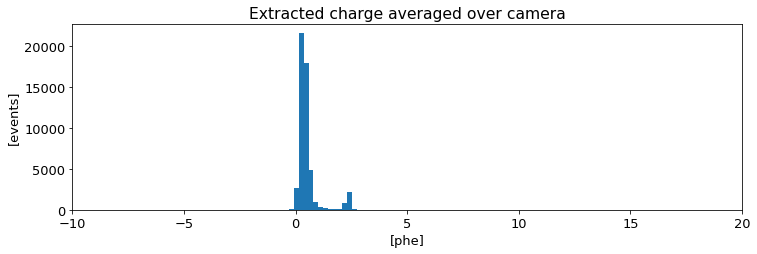

In [33]:
dl1_data = tables.open_file(subrun_dl1_path)
dl1_images = dl1_data.root.dl1.event.telescope.image.LST_LSTCam

images = [x['image'] for x in dl1_images.iterrows()]
timing = [x['peak_time'] for x in dl1_images.iterrows()]
image_averages = [np.average(y) for y in images]

rcParams['figure.figsize'] = 12, 7.5
plt.subplot(2, 1, 1)
h = plt.hist(image_averages, bins=1000)
plt.title('Extracted charge averaged over camera')
plt.xlabel('[phe]')
plt.ylabel('[events]')
plt.xlim(-10,20)
plt.show()

In [35]:
for j, lowlevel_config in enumerate(real_lowlevel_configs):
    logger.warning('===== {conf} ====='.format(conf=lowlevel_config.abbreviation))
    for k, run in enumerate(real_runs):
        logger.warning('Run {run}'.format(run=run))
        dl1_data = real_dl1_data_dict[lowlevel_config][run]
        interleaved_pedestal = np.array(dl1_data.parameter_value_dict["event_type"])==EventType.SKY_PEDESTAL.value
        survived_pedestal = (np.array(dl1_data.parameter_value_dict["event_type"])==EventType.SKY_PEDESTAL.value) * (np.array(dl1_data.parameter_value_dict["intensity"])>0)
        #survived_flatfield = (np.array(dl1_data.parameter_value_dict["event_type"])==EventType.FLATFIELD.value) * (np.array(dl1_data.parameter_value_dict["intensity"])>0)
        logger.warning('    {n} pedestal events survived.'.format(n=sum(survived_pedestal))) 
        logger.info('    Survived fraction: {pf:3.3f}%'.format(pf=100*sum(survived_pedestal)/sum(interleaved_pedestal)))

===== TPWS_c5_pth8_bth4 =====
Run 3948
    1 pedestal events survived.
    Survived fraction: 0.138%
Run 4699
    0 pedestal events survived.
    Survived fraction: 0.000%
Run 2181
    0 pedestal events survived.
    Survived fraction: 0.000%
Run 4859
    0 pedestal events survived.
    Survived fraction: 0.000%
===== TPWS_c6_pth8_bth4 =====
Run 3948
    0 pedestal events survived.
    Survived fraction: 0.000%
Run 4699
    0 pedestal events survived.
    Survived fraction: 0.000%
Run 2181
    0 pedestal events survived.
    Survived fraction: 0.000%
Run 4859
    0 pedestal events survived.
    Survived fraction: 0.000%
===== TPWS_c7_pth8_bth4 =====
Run 3948
    0 pedestal events survived.
    Survived fraction: 0.000%
Run 4699
    0 pedestal events survived.
    Survived fraction: 0.000%
Run 2181
    0 pedestal events survived.
    Survived fraction: 0.000%
Run 4859
    0 pedestal events survived.
    Survived fraction: 0.000%
===== TPWS_c5_pth6_bth3 =====
Run 3948
    16 pedestal eve

/tmp/ipykernel_14336/3054824770.py:32: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


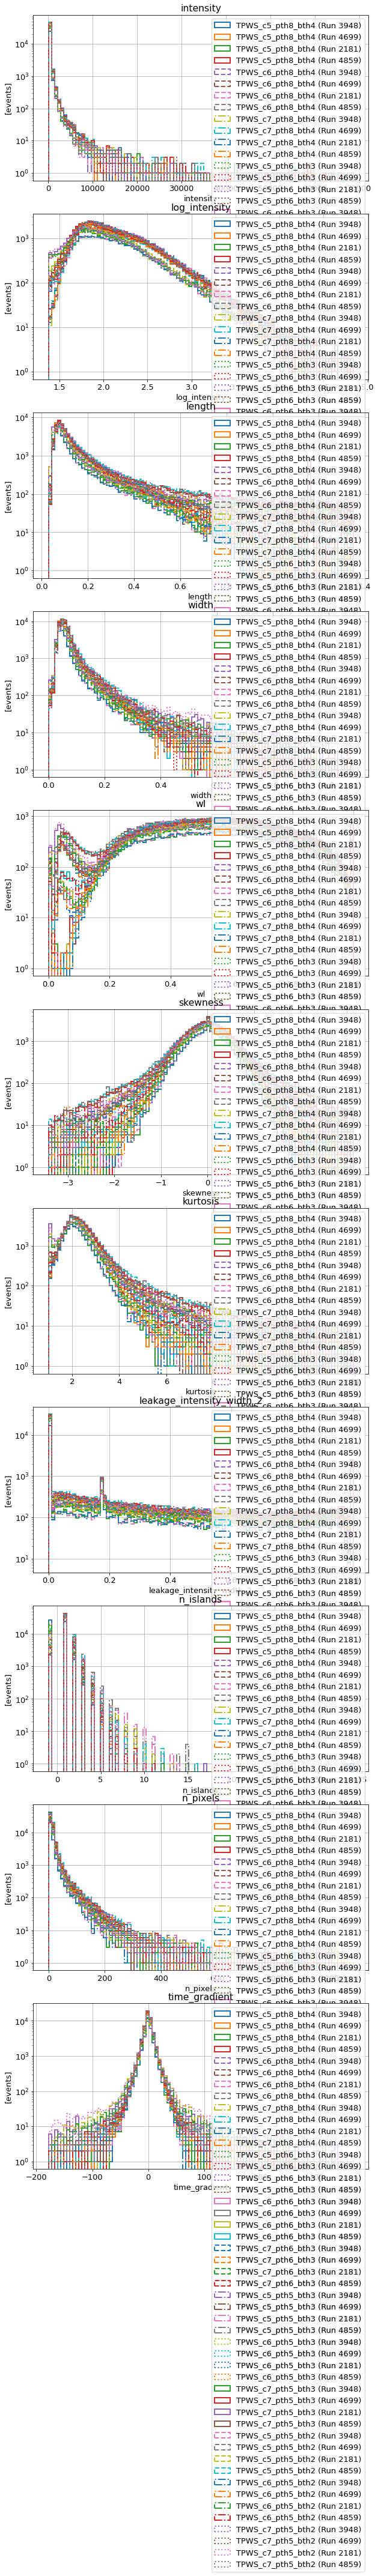

In [36]:
fig, axes = plt.subplots(len(HILLASES_OF_INTEREST), 1, figsize=(10, 6*len(HILLASES_OF_INTEREST)))
hist_results = {}

for i, param in enumerate(HILLASES_OF_INTEREST):
    for j, lowlevel_config in enumerate(real_lowlevel_configs):
        for k, run in enumerate(real_runs):
            dl1_data = real_dl1_data_dict[lowlevel_config][run]
            # Mask events
            event_masks = {}
            for mask_key in [EventType.FLATFIELD, EventType.SKY_PEDESTAL]:
                event_masks[mask_key] = np.array(dl1_data.parameter_value_dict["event_type"])==mask_key.value
            event_masks["intensity>100000"] = np.array(dl1_data.parameter_value_dict["intensity"])>100000
            event_masks["width<=0"] = np.array(dl1_data.parameter_value_dict["width"])<=0            
            mask_sum = np.zeros_like(dl1_data.parameter_value_dict[param])
            for mask_array in event_masks.values():
                mask_sum += mask_array
            #mask_trigger = np.array(dl1_data.parameter_value_dict["intensity"])>20000
            
            vals = ma.masked_array(dl1_data.parameter_value_dict[param], mask=mask_sum)
            label = '{0} (Run {1})'.format(lowlevel_config.abbreviation, run)
            if not param in hist_results.keys():
                hist_results[param] = axes[i].hist(vals, lw=2, ls=LINE_STYLES[k], bins=100, histtype="step", label=label)
            else:
                axes[i].hist(vals, lw=2, ls=LINE_STYLES[j%len(LINE_STYLES)], bins=hist_results[param][1], histtype="step", label=label)
    axes[i].set_title(param)
    axes[i].grid(True, which='major', axis='both')
    axes[i].set_yscale('log')
    #axes[i].set_ylim(1e-3, 1)
    axes[i].set_xlabel(param)
    axes[i].set_ylabel('[events]')
    axes[i].legend(loc=0)    
plt.tight_layout()  

# MC DL0 data

In [37]:
N_MCEVENTS = 50

dl0_paths = []
for i in range(1, N_MCEVENTS+1):
    dl0_paths.append(Path('/fefs/aswg/data/mc/DL0/20200629_prod5_trans_80/proton/zenith_20deg/south_pointing/proton_20deg_180deg_run{r}___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.simtel.gz'.format(r=i)))

#dl0_path = Path('/fefs/aswg/workspace/yoshiki.ohtani/Data/LaPalma/4LSTs_MAGIC/gamma-diffuse/zenith_20deg/south_pointing/run1000/sim_telarray_v3_trans_80%/cta-prod5-lapalma_4LSTs_MAGIC/0.0deg/Data/gamma_20deg_180deg_run1000___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono_cone6.simtel.gz')
#dl0_path = Path('/fefs/aswg/data/mc/DL0/20200629_prod5/gamma-diffuse/zenith_20deg/south_pointing/gamma_20deg_180deg_run1___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono_cone6.simtel.gz')

In [38]:
dl0_data = DL0Data(name='DL0 MC Proton', emin=EMIN, emax=EMAX, tel_id=tel_id)

In [39]:
dl0_datum_list = []
for idatum, dl0_path in enumerate(dl0_paths):
    dl0_datum_list.append(DL0DataSingleFile(name='{0}_{1}'.format(dl0_data.name, idatum), 
                                            file_path=dl0_path, 
                                            emin=EMIN, emax=EMAX, 
                                            tel_id=tel_id))
dl0_data.add_data(datum_list=dl0_datum_list)

37 events has been added.
50 events has been added.
36 events has been added.
39 events has been added.
47 events has been added.
41 events has been added.
47 events has been added.
43 events has been added.
39 events has been added.
50 events has been added.
47 events has been added.
42 events has been added.
38 events has been added.
38 events has been added.
26 events has been added.
45 events has been added.
41 events has been added.
51 events has been added.
36 events has been added.
36 events has been added.
38 events has been added.
42 events has been added.
50 events has been added.
32 events has been added.
36 events has been added.
40 events has been added.
34 events has been added.
42 events has been added.
26 events has been added.
56 events has been added.
42 events has been added.
60 events has been added.
35 events has been added.
45 events has been added.
44 events has been added.
40 events has been added.
37 events has been added.
47 events has been added.
53 events ha


# MC DL1 data

In [40]:
dl1_data_dict = {}
for lowlevel_config in lowlevel_configs:
    logger.info(lowlevel_config.name)
    dl1_datum_list = []
    for dl0_datum in dl0_datum_list:
        dl1_datum_list.append(dl0_datum.produce_mc_dl1(lowlevel_config=lowlevel_config, 
                                                       hillas_parameters=REQUSTED_PARAMETERS))
        #print(dl1_datum_list[-1].true_phe)
        #print(len(dl1_datum_list[-1].dl1_image_tables))
        #print(dl1_datum_list[-1].file_path)
    dl1_data_dict[lowlevel_config] = DL1Data(name=dl0_data.name.replace('DL0','DL1').replace('dl0','dl1'),
                                             datasrc=dl0_data.DATASRC,
                                             hillas_parameters=REQUSTED_PARAMETERS,
                                             emin=EMIN, emax=EMAX, tel_id=tel_id)
    dl1_data_dict[lowlevel_config].add_data(datum_list=dl1_datum_list)
    if dl0_data.true_phe.size!=dl1_data_dict[lowlevel_config].dl1_reco_phe.size:
        logger.critical('The pulse number of DL0 ({0}) and that of DL1 ({1}) does not match!!!'\
                        .format(dl0_data.true_phe.size, dl1_data_dict[lowlevel_config].dl1_reco_phe.size))

TwoPassWindowSum_core_threshold5_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2

Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, s

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold6_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run3___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 1 days 6 hours 5 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold6_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run4___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 1 days 6 hours 4 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold6_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run21___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 1 days 5 hours 4 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold6_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run22___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 1 days 5 hours 3 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_co

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold6_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run39___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 1 days 4 hours 41 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold6_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run40___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 1 days 4 hours 40 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_

TwoPassWindowSum_core_threshold7_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh8_boundary_thresh4_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2

Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, s


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplic

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold6_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run4___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 1 days 7 hours 9 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold6_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run5___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 1 days 7 hours 8 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold6_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run22___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 1 days 5 hours 51 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold6_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run23___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 1 days 5 hours 50 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_

/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold6_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run40___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 1 days 5 hours 37 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_core_threshold6_disable_second_passfalse_apply_integration_correctiontrue_Tailcut_picture_thresh6_boundary_thresh3_sigma2.5_keep_isolated_pixelsfalse_min_number_picture_neighbors2_use_only_main_islandfalse_delta_time2/mc/DL1/dl1_proton_20deg_180deg_run41___cta-prod5-lapalma_4LSTs_MAGIC_desert-2158m_mono.h5 already exists! It was modified 1 days 5 hours 36 minutes before.
/home/mitsunari.takahashi/Work/analysis/low-level/LowLevelAnalyses/TwoPassWindowSum_


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplic


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplic


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplic


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplic


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplic


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


srun: job 14236025 queued and waiting for resources
srun: job 14236025 has been allocated resources
Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping

Adding [<LowLevelData.DL1DataSingleFile object at 0x7f2f67e0f6d0>, <LowLevelData.DL1DataSingleFile object at 0x7f2f67c952b0>, <LowLevelData.DL1DataSingleFile object at 0x7f2f67bc08b0>, <LowLevelData.DL1DataSingleFile object at 0x7f2f67be4c70>, <LowLevelData.DL1DataSingleFile object at 0x7f2f67c95040>, <LowLevelData.DL1DataSingleFile object at 0x7f2f67611940>, <LowLevelData.DL1DataSingleFile object at 0x7f2f678339d0>, <LowLevelData.DL1DataSingleFile object at 0x7f2f6


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping


Found duplicated column obs_id, skipping
Found duplicated column event_id, skipping

Adding [<LowLevelData.DL1DataSingleFile object at 0x7f2f67be4c70>, <LowLevelData.DL1DataSingleFile object at 0x7f2f67426310>, <LowLevelData.DL1DataSingleFile object at 0x7f2f671c99a0>, <LowLevelData.DL1DataSingleFile object at 0x7f2f66f95fd0>, <LowLevelData.DL1DataSingleFile object at 0x7f2f66fc39a0>, <LowLevelData.DL1DataSingleFile object at 0x7f2f6708a100>, <LowLevelData.DL1DataSingleFile object at 0x7f2f670a9820>, <LowLevelData.DL1DataSingleFile object at 0x7f2f670b1820>, <LowLevelData.DL1DataSingleFile object at 0x7f2f67092130>, <LowLevelData.DL1DataSingleFile object at 0x7f2f66cf0700>, <LowLevelData.DL1DataSingleFile object at 0x7f2f6725ef70>, <LowLevelData.DL1DataSingleFile object at 0x7f2f66d21bb0>, <LowLevelData.DL1DataSingl

In [41]:
len(dl1_data_dict[lowlevel_config].dl1_image_tables)

2140

## DL1 Data Readout

In [42]:

#dl1_datum_list = []
#for idatum, dl1_path in enumerate(dl0_paths):
#    dl0_datum_list.append(DL0DataSingleFile(name='{0}_{1}'.format(dl0_data.name, idatum), file_path=dl0_path, emin=EMIN, emax=EMAX, tel_id=tel_id))
#dl0_data.add_data(datum_list=dl0_datum_list)

In [43]:
#for lowlevel_config in lowlevel_configs:
#    lowlevel_config.read_dl1(event_used, tel_id=1, hillas_parameters=HILLASES_OF_INTEREST)#emin=EMIN, emax=EMAX)
#    if len(lowlevel_config.dl1_reco_phe)!=len(true_phe):
#        logger.critical('The pulse number of DL0 and DL1 does not match!!!')

In [44]:
for lowlevel_config in lowlevel_configs:
    dl1_data_dict[lowlevel_config].make_hist_pulselevel()

# Plot

/tmp/ipykernel_14336/1724184096.py:48: RuntimeWarning: invalid value encountered in true_divide
  yerr=dl1_data.reco_phe_stats['std'][0]/np.sqrt(dl1_data.reco_phe_stats['count'][0]), \
/tmp/ipykernel_14336/1724184096.py:54: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes[iax][0].set_ylim(-1, 10)
/tmp/ipykernel_14336/1724184096.py:62: RuntimeWarning: invalid value encountered in true_divide
  yerr=dl1_data.reco_phe_stats_log['std'][0]/np.sqrt(dl1_data.reco_phe_stats_log['count'][0]), \
/tmp/ipykernel_14336/1724184096.py:77: RuntimeWarning: invalid value encountered in true_divide
  yerr=dl1_data.reco_phe_frac_stats['std'][0][1:]/np.sqrt(dl1_data.reco_phe_frac_stats['count'][0][1:]), \
/tmp/ipykernel_14336/1724184096.py:89: RuntimeWarning: invalid value encountered in true_divide
  yerr=dl1_data.reco_phe_frac_stats_log['std'][0]/np.sqrt(dl1_data.reco_phe_frac_stats_log['count'][0]), \
/tmp/ipykernel_14336/1724184096.py:14

/tmp/ipykernel_14336/1724184096.py:54: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes[iax][0].set_ylim(-1, 10)
/tmp/ipykernel_14336/1724184096.py:62: RuntimeWarning: invalid value encountered in true_divide
  yerr=dl1_data.reco_phe_stats_log['std'][0]/np.sqrt(dl1_data.reco_phe_stats_log['count'][0]), \
/tmp/ipykernel_14336/1724184096.py:77: RuntimeWarning: invalid value encountered in true_divide
  yerr=dl1_data.reco_phe_frac_stats['std'][0][1:]/np.sqrt(dl1_data.reco_phe_frac_stats['count'][0][1:]), \
/tmp/ipykernel_14336/1724184096.py:89: RuntimeWarning: invalid value encountered in true_divide
  yerr=dl1_data.reco_phe_frac_stats_log['std'][0]/np.sqrt(dl1_data.reco_phe_frac_stats_log['count'][0]), \
/tmp/ipykernel_14336/1724184096.py:147: RuntimeWarning: invalid value encountered in true_divide
  dl1_data.reco_phe_stats['std'][0][1:] / \
/tmp/ipykernel_14336/1724184096.py:48: RuntimeWarning: invalid value encountered 

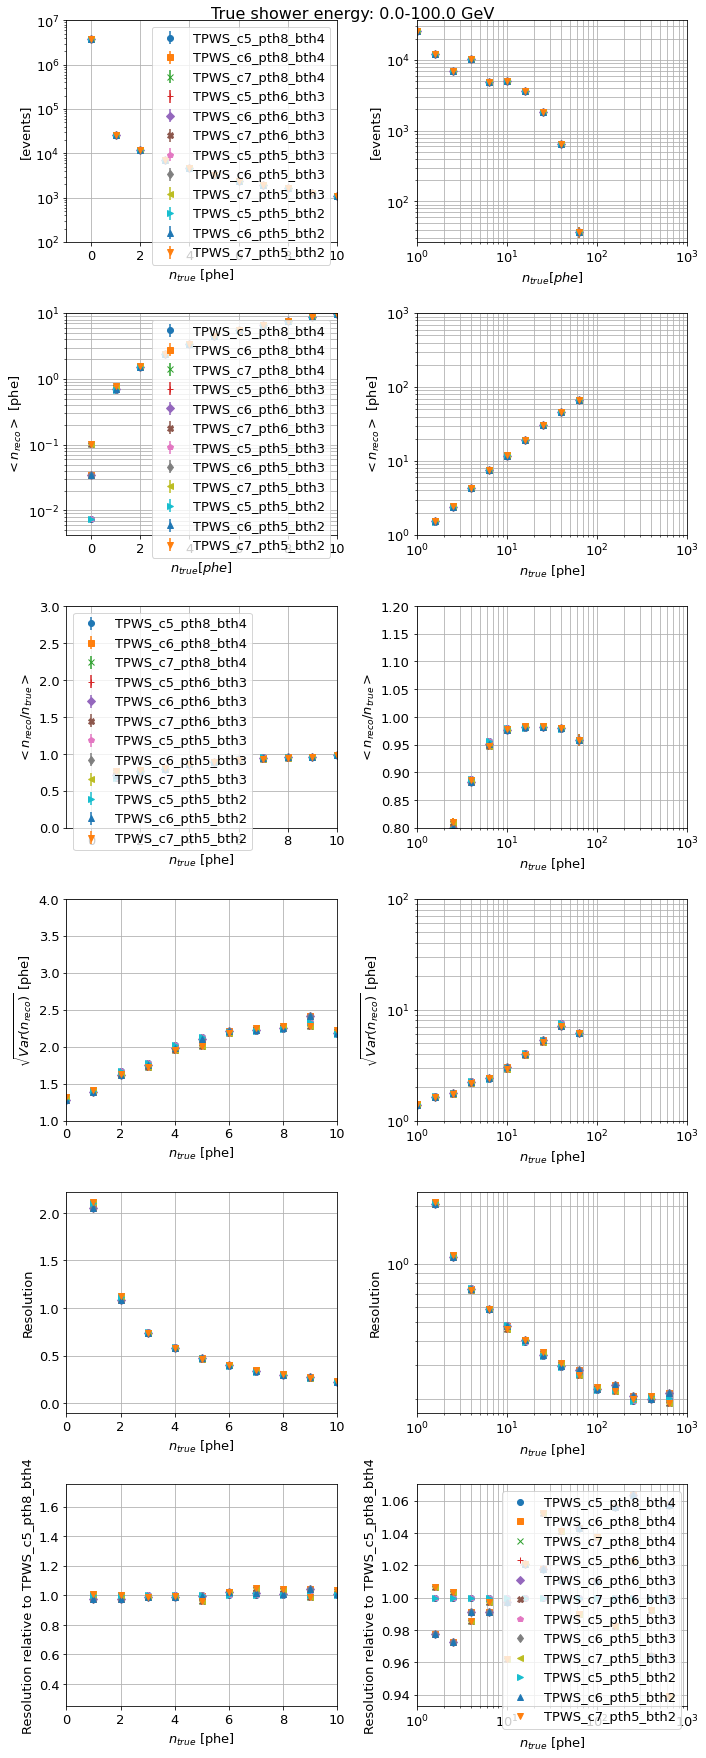

In [45]:
lowlevel_config_benchmark = lowlevel_configs[0]
dl1_data_benchmark = dl1_data_dict[lowlevel_config_benchmark]

fig, axes = plt.subplots(6, 2, figsize=(10, 25))
fig.suptitle('True shower energy: {0:.1f}-{1:.1f} GeV'.format(EMIN.to(u.GeV).value, EMAX.to(u.GeV).value), fontsize=16)
for i, lowlevel_config in enumerate(lowlevel_configs):
    dl1_data = dl1_data_dict[lowlevel_config]
    iax = 0
    
    # Linear X-axis
    xvalues = (dl1_data.reco_phe_stats['mean'][1][:-1])
    
    # Log X-axis    
    logxvalues = (dl1_data.reco_phe_stats_log['mean'][1][:-1])
        
    # Event count 
    axes[iax][0].errorbar(xvalues, \
                          dl1_data.reco_phe_stats['count'][0], \
                          yerr=np.sqrt(dl1_data.reco_phe_stats['count'][0]), \
                          fmt=MARKER_STYLES[i%len(MARKER_STYLES)], \
                          label=lowlevel_config.abbreviation)
    axes[iax][0].grid(True, which='major', axis='both')
    axes[iax][0].set_yscale('log')
    axes[iax][0].set_xlim(-1, 10)
    axes[iax][0].set_ylim(100, 1e7)
    axes[iax][0].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][0].set_ylabel('[events]')
    #axes[iax][0].legend(loc=0)


    axes[iax][1].errorbar(logxvalues, \
                          dl1_data.reco_phe_stats_log['count'][0], \
                          yerr=np.sqrt(dl1_data.reco_phe_stats_log['count'][0]), \
                          fmt=MARKER_STYLES[i%len(MARKER_STYLES)], \
                          label=lowlevel_config.abbreviation)
    axes[iax][1].set_xscale('log')
    axes[iax][1].set_yscale('log')
    axes[iax][1].set_xlim(1, 1000)
    #axes[iax][1].set_ylim(1, 1000)
    axes[iax][1].grid(True, which='both', axis='both')
    axes[iax][1].set_xlabel(r'$n_{true} [phe]$')
    axes[iax][1].set_ylabel('[events]')
                         
    iax += 1
        
    axes[iax][0].errorbar(xvalues, \
                          dl1_data.reco_phe_stats['mean'][0], \
                          yerr=dl1_data.reco_phe_stats['std'][0]/np.sqrt(dl1_data.reco_phe_stats['count'][0]), \
                          fmt=MARKER_STYLES[i%len(MARKER_STYLES)], \
                          label=lowlevel_config.abbreviation)
    axes[iax][0].grid(True, which='both', axis='both')
    axes[iax][0].set_yscale('log')
    axes[iax][0].set_xlim(-1, 10)
    axes[iax][0].set_ylim(-1, 10)
    axes[iax][0].set_xlabel(r'$n_{true} [phe]$')
    axes[iax][0].set_ylabel(r'$<n_{reco}>$ [phe]')
    axes[iax][0].legend(loc=0)


    axes[iax][1].errorbar(logxvalues, \
                          dl1_data.reco_phe_stats_log['mean'][0], \
                          yerr=dl1_data.reco_phe_stats_log['std'][0]/np.sqrt(dl1_data.reco_phe_stats_log['count'][0]), \
                          fmt=MARKER_STYLES[i%len(MARKER_STYLES)], \
                          label=lowlevel_config.abbreviation)
    axes[iax][1].set_xscale('log')
    axes[iax][1].set_yscale('log')
    axes[iax][1].set_xlim(1, 1000)
    axes[iax][1].set_ylim(1, 1000)
    axes[iax][1].grid(True, which='both', axis='both')
    axes[iax][1].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][1].set_ylabel(r'$<n_{reco}>$ [phe]')
                         
    iax += 1

    axes[iax][0].errorbar(xvalues[1:], \
                          dl1_data.reco_phe_frac_stats['mean'][0][1:], \
                          yerr=dl1_data.reco_phe_frac_stats['std'][0][1:]/np.sqrt(dl1_data.reco_phe_frac_stats['count'][0][1:]), \
                          fmt=MARKER_STYLES[i%len(MARKER_STYLES)], \
                    label=lowlevel_config.abbreviation)
    axes[iax][0].grid(True, which='both', axis='both')
    axes[iax][0].set_xlim(-1, 10)
    axes[iax][0].set_ylim(0, 3)
    axes[iax][0].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][0].set_ylabel(r'$<n_{reco}/n_{true}>$')

    # Log X-axis    
    axes[iax][1].errorbar(logxvalues, \
                          dl1_data.reco_phe_frac_stats_log['mean'][0], \
                          yerr=dl1_data.reco_phe_frac_stats_log['std'][0]/np.sqrt(dl1_data.reco_phe_frac_stats_log['count'][0]), \
                          fmt=MARKER_STYLES[i%len(MARKER_STYLES)], \
                          label=lowlevel_config.abbreviation)
    axes[iax][1].set_xscale('log')
    axes[iax][1].set_xlim(1, 1000)
    axes[iax][1].set_ylim(0.8, 1.2)
    axes[iax][1].grid(True, which='both', axis='both')
    axes[iax][1].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][1].set_ylabel(r'$<n_{reco}/n_{true}>$')
                         
    iax += 1
    
    axes[iax][0].plot(xvalues, \
                    dl1_data.reco_phe_stats['std'][0], MARKER_STYLES[i%len(MARKER_STYLES)], \
                    label=lowlevel_config.abbreviation)
    axes[iax][0].grid(True, which='both', axis='both')
    axes[iax][0].set_xlim(0, 10)
    axes[iax][0].set_ylim(1, 4)
    axes[iax][0].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][0].set_ylabel(r'$\sqrt{Var(n_{reco})}$ [phe]')

    axes[iax][1].plot(logxvalues, \
                    dl1_data.reco_phe_stats_log['std'][0], MARKER_STYLES[i%len(MARKER_STYLES)], \
                    label=lowlevel_config.abbreviation)
    axes[iax][1].set_xscale('log')
    axes[iax][1].set_yscale('log')
    axes[iax][1].grid(True, which='both', axis='both')
    axes[iax][1].set_xlim(1, 1000)
    axes[iax][1].set_ylim(1, 100)
    axes[iax][1].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][1].set_ylabel(r'$\sqrt{Var(n_{reco})}$ [phe]')   
                         
    iax += 1
    axes[iax][0].plot(xvalues[1:], \
                    dl1_data.reco_phe_stats['std'][0][1:] / \
                    (dl1_data.reco_phe_stats['mean'][0][1:]-dl1_data.mean_phe_true0), \
                    MARKER_STYLES[i%len(MARKER_STYLES)], \
                    label=lowlevel_config.abbreviation)
    axes[iax][0].grid(True, which='both', axis='both')
    axes[iax][0].set_xlim(0, 10)
    axes[iax][0].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][0].set_ylabel('Resolution') #(r'$\sqrt{Var(n_{reco})} / (\bar{n}_{reco}-\bar{n}_{reco}(n_{true}=0))$')

    axes[iax][1].plot(logxvalues[1:], \
                    dl1_data.reco_phe_stats['std'][0][1:len(logxvalues)] / \
                    (dl1_data.reco_phe_stats['mean'][0][1:len(logxvalues)]-dl1_data.mean_phe_true0), \
                    MARKER_STYLES[i%len(MARKER_STYLES)], \
                    label=lowlevel_config.abbreviation)
    axes[iax][1].set_xscale('log')
    axes[iax][1].set_yscale('log')
    axes[iax][1].grid(True, which='both', axis='both')
    axes[iax][1].set_xlim(1, 1000)
    #axes[iax][0].set_ylim(0, 3)
    axes[iax][1].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][1].set_ylabel('Resolution')#r'$\sqrt{Var(n_{reco})} / (\bar{n}_{reco}-\bar{n}_{reco}(n_{true}=0))$')
    
    iax += 1
    axes[iax][0].plot(xvalues[1:], \
                      dl1_data.reco_phe_stats['std'][0][1:] / \
                      dl1_data_benchmark.reco_phe_stats['std'][0][1:] / \
                      (dl1_data.reco_phe_stats['mean'][0][1:]-dl1_data.mean_phe_true0) * \
                      (dl1_data_benchmark.reco_phe_stats['mean'][0][1:]-dl1_data_benchmark.mean_phe_true0), \
                      MARKER_STYLES[i%len(MARKER_STYLES)], label=lowlevel_config.abbreviation)
    axes[iax][0].grid(True, which='both', axis='both')
    axes[iax][0].set_xlim(0, 10)
    axes[iax][0].set_ylim(0.25, 1.75)
    axes[iax][0].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][0].set_ylabel('Resolution relative to {0}'.format(lowlevel_config_benchmark.abbreviation))    

    axes[iax][1].plot(logxvalues[1:], \
                      dl1_data.reco_phe_stats['std'][0][1:len(logxvalues)] / \
                      dl1_data_benchmark.reco_phe_stats['std'][0][1:len(logxvalues)] / \
                      (dl1_data.reco_phe_stats['mean'][0][1:len(logxvalues)]-dl1_data.mean_phe_true0) * \
                      (dl1_data_benchmark.reco_phe_stats['mean'][0][1:len(logxvalues)]-dl1_data_benchmark.mean_phe_true0), \
                      MARKER_STYLES[i%len(MARKER_STYLES)], label=lowlevel_config.abbreviation)
    axes[iax][1].set_xscale('log')
    #axes[iax][1].set_yscale('log')
    axes[iax][1].grid(True, which='both', axis='both')
    axes[iax][1].set_xlim(1, 1000)
    #axes[iax][0].set_ylim(0, 3)
    axes[iax][1].set_xlabel(r'$n_{true}$ [phe]')
    axes[iax][1].set_ylabel('Resolution relative to {0}'.format(lowlevel_config_benchmark.abbreviation))
    
axes[0][0].legend(loc=0)   
axes[2][0].legend(loc=0)
axes[5][1].legend(loc=0)
plt.tight_layout()    

## Distribution for specific-phe-number events

In [37]:
list_true_phes = [0, 3, 6, 10] #List of the true photoelectron numbers to draw the distribution of the reconstructed phe
mask_truephe = {}
true_phe_bins = np.linspace(-10, 30, 81)

for i, lowlevel_config in enumerate(lowlevel_configs):
    dl1_data = dl1_data_dict[lowlevel_config]    
    for tphe in list_true_phes:
        mask_truephe[tphe] = np.array(dl1_data.true_phe!=tphe)
        dl1_data.reco_phe_hists[tphe] = np.histogram(dl1_data.dl1_reco_phe, \
                                                     weights=[float(1-m) for m in mask_truephe[tphe]], \
                                                     bins=true_phe_bins)

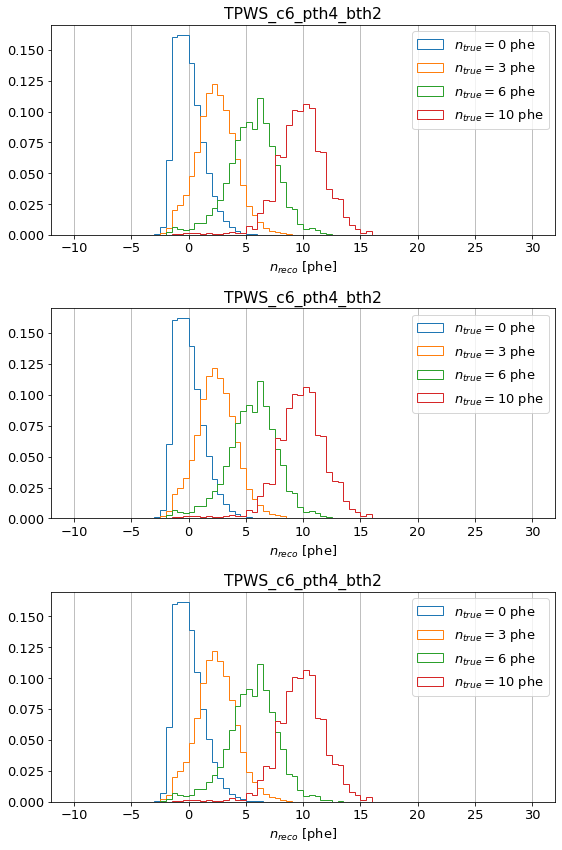

In [38]:
fig, axes = plt.subplots(len(lowlevel_configs), 1, figsize=(8, 4*len(lowlevel_configs)))
for i, image_extracter_config in enumerate(lowlevel_configs):
    dl1_data = dl1_data_dict[lowlevel_config]     
    for j, tphe in enumerate(list_true_phes):
        axes[i].hist(dl1_data.reco_phe_hists[tphe][1][:-1], \
                     dl1_data.reco_phe_hists[tphe][1], \
                     weights=dl1_data.reco_phe_hists[tphe][0]/sum(dl1_data.reco_phe_hists[tphe][0]), \
                     label=r'$n_{{true}}={{{0}}}$ phe'.format(tphe), histtype='step')#, alpha=0.2)
    axes[i].set_title(lowlevel_config.abbreviation)
    axes[i].grid(True, which='major', axis='x')
    axes[i].set_xlabel(r'$n_{reco}$ [phe]')
    axes[i].legend(loc=0)    
plt.tight_layout()  

## ROC Curve

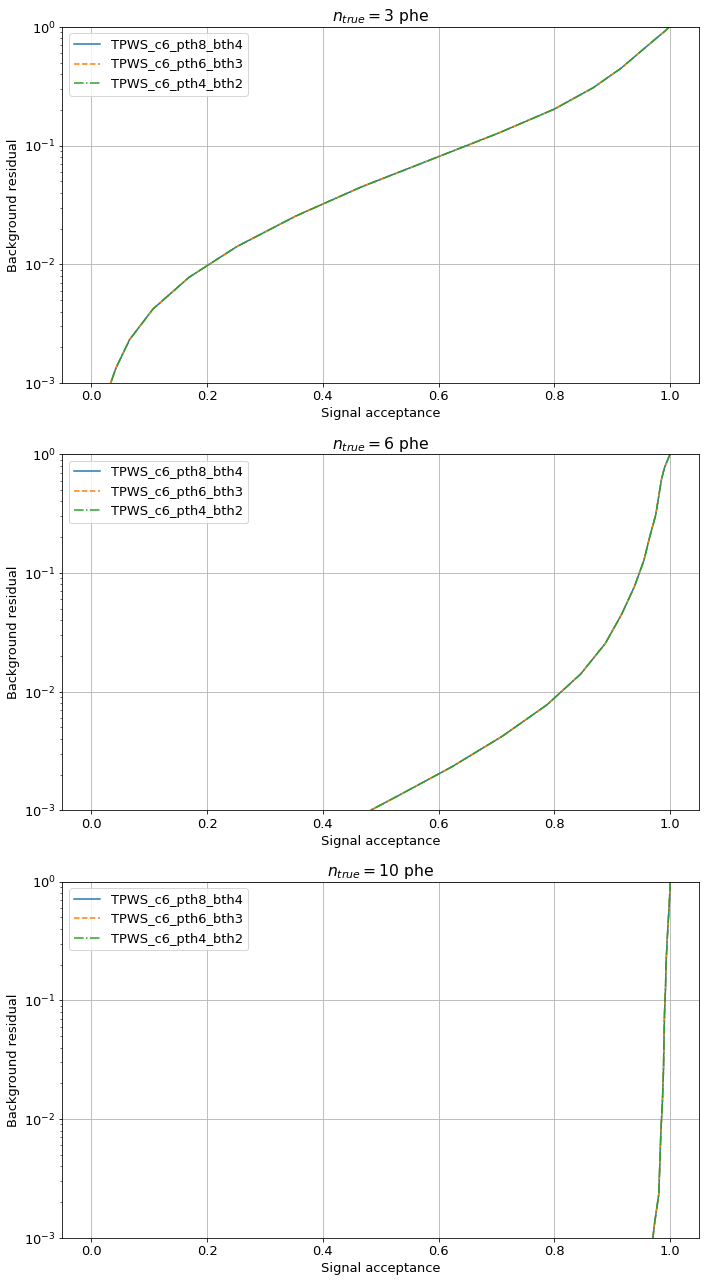

In [39]:

sig_phes = [3, 6, 10]
fig, axes = plt.subplots(len(sig_phes), 1, figsize=(10, 6*len(sig_phes)))

for i, sig_phe in enumerate(sig_phes):
    for j, lowlevel_config in enumerate(lowlevel_configs):
        dl1_data = dl1_data_dict[lowlevel_config] 
        xvals, yvals = dl1_data.get_roc_curve(sig_phe=sig_phe)
        axes[i].plot(xvals, yvals, label=lowlevel_config.abbreviation, ls=LINE_STYLES[j%len(LINE_STYLES)])
    axes[i].set_title(r'$n_{{true}}={0}$ phe'.format(sig_phe))
    axes[i].grid(True, which='major', axis='both')
    axes[i].set_yscale('log')
    axes[i].set_ylim(1e-3, 1)
    axes[i].set_xlabel('Signal acceptance')
    axes[i].set_ylabel('Background residual')
    axes[i].legend(loc=0)    
plt.tight_layout()  


# Separation power evaluation
Not working well yet

In [40]:
#for i, lowlevel_config in enumerate(lowlevel_configs):
#    logger.info(lowlevel_config.name)
#    lowlevel_config.find_best_separation('error', [0,3])

In [41]:
#for i, lowlevel_config in enumerate(lowlevel_configs):
#    logger.info(lowlevel_config.name)
#    lowlevel_config.find_best_separation('error', [0,6])

In [42]:
#for i, lowlevel_config in enumerate(lowlevel_configs):
#    logger.info(lowlevel_config.name)
#    lowlevel_config.find_best_separation('error', [0,10])

# Hillas Parameters

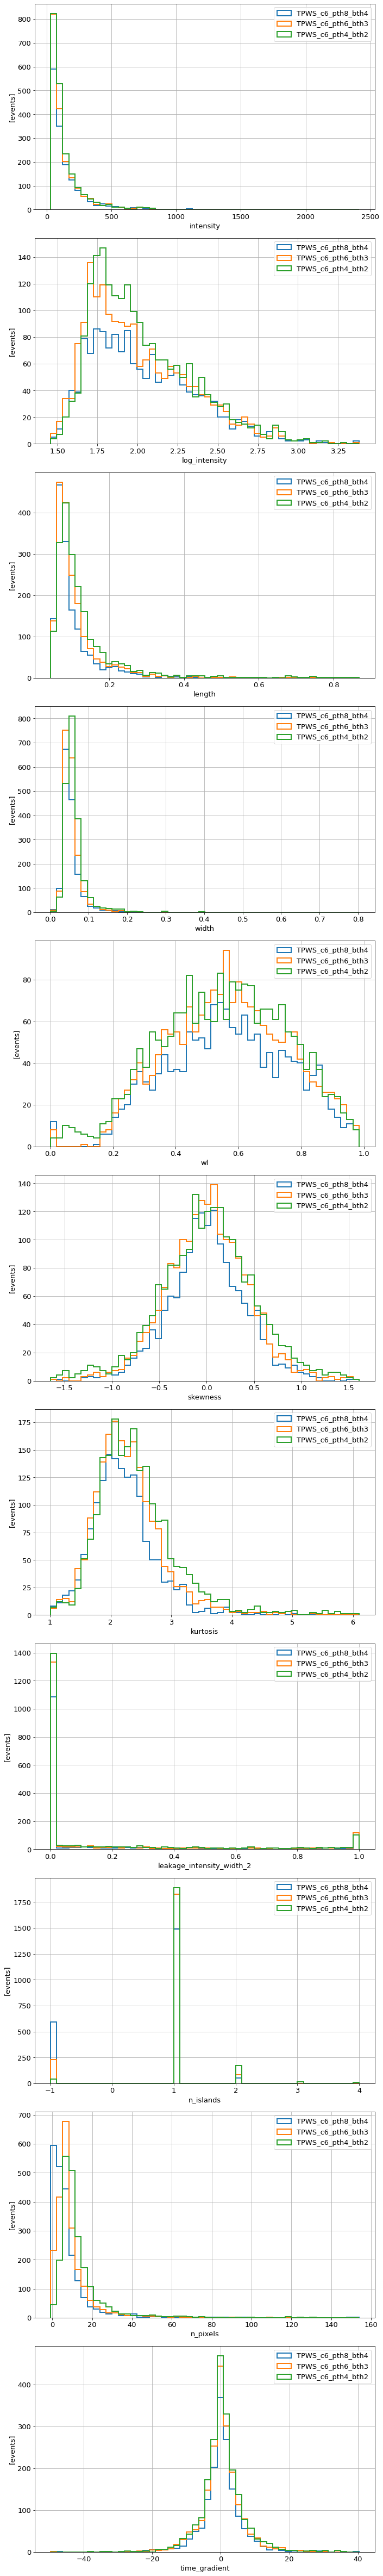

In [43]:
fig, axes = plt.subplots(len(HILLASES_OF_INTEREST), 1, figsize=(10, 6*len(HILLASES_OF_INTEREST)))

for i, param in enumerate(HILLASES_OF_INTEREST):
    for j, lowlevel_config in enumerate(lowlevel_configs):
        dl1_data = dl1_data_dict[lowlevel_config] 
        vals = dl1_data.parameter_value_dict[param]
        if j==0:
            hist_result = axes[i].hist(vals, lw=2, bins=50, histtype="step", label=lowlevel_config.abbreviation)
        else:
            axes[i].hist(vals, lw=2, bins=hist_result[1], histtype="step", label=lowlevel_config.abbreviation)
    #axes[i].set_title(param)
    axes[i].grid(True, which='major', axis='both')
    #axes[i].set_yscale('log')
    #axes[i].set_ylim(1e-3, 1)
    axes[i].set_xlabel(param)
    axes[i].set_ylabel('[events]')
    axes[i].legend(loc=0)    
plt.tight_layout()  

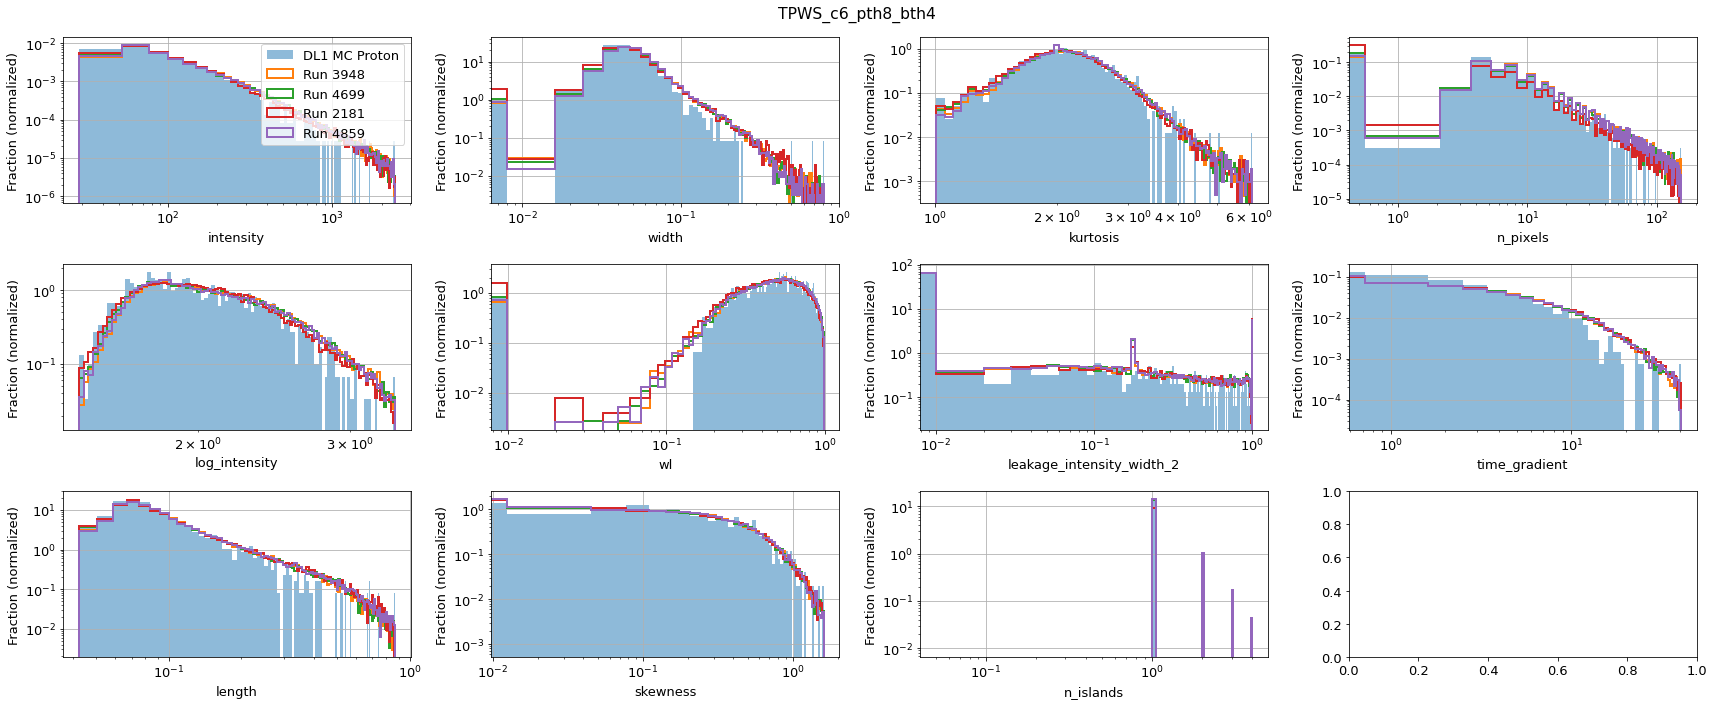

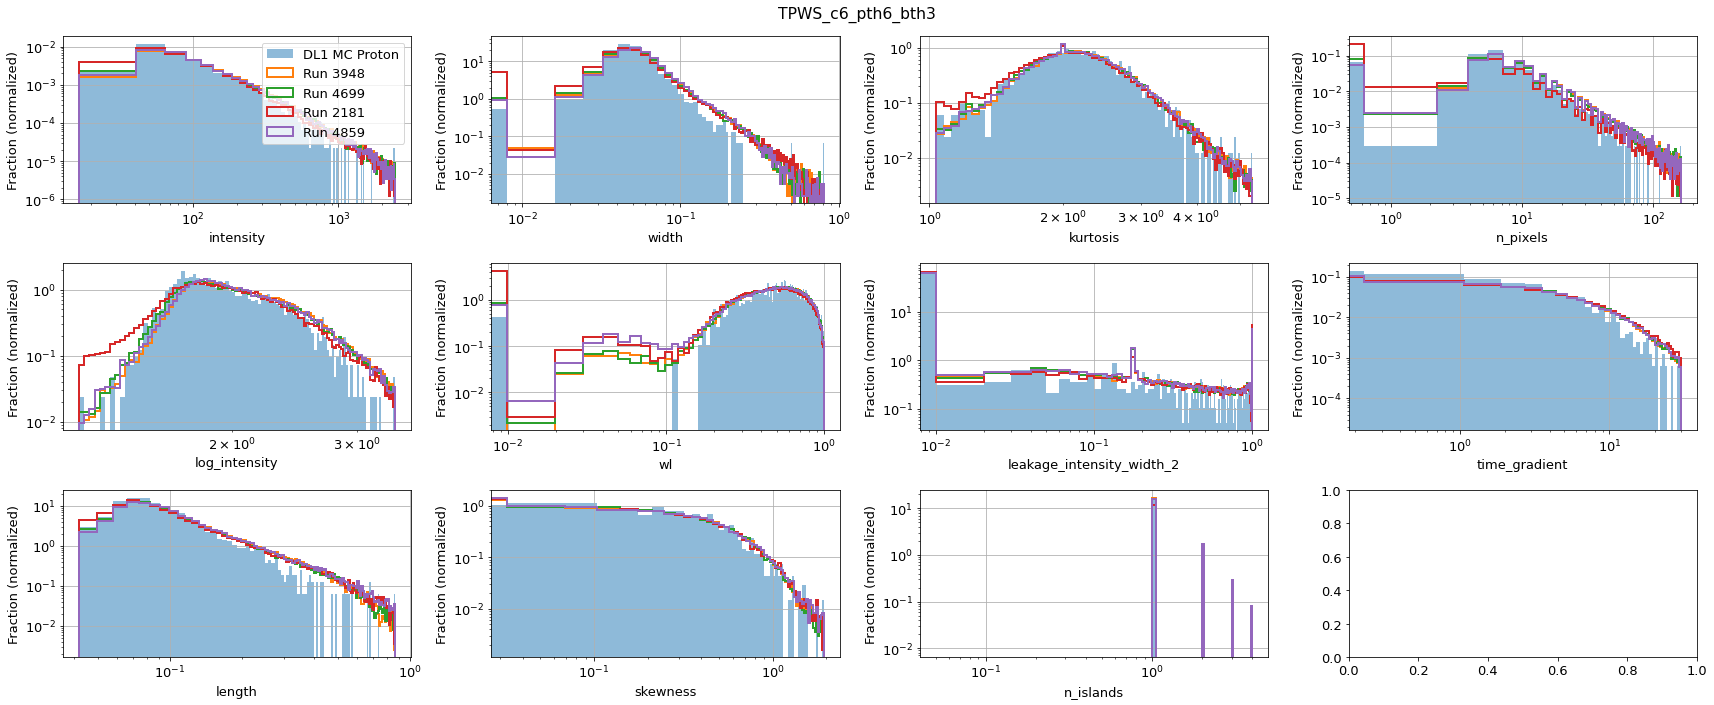

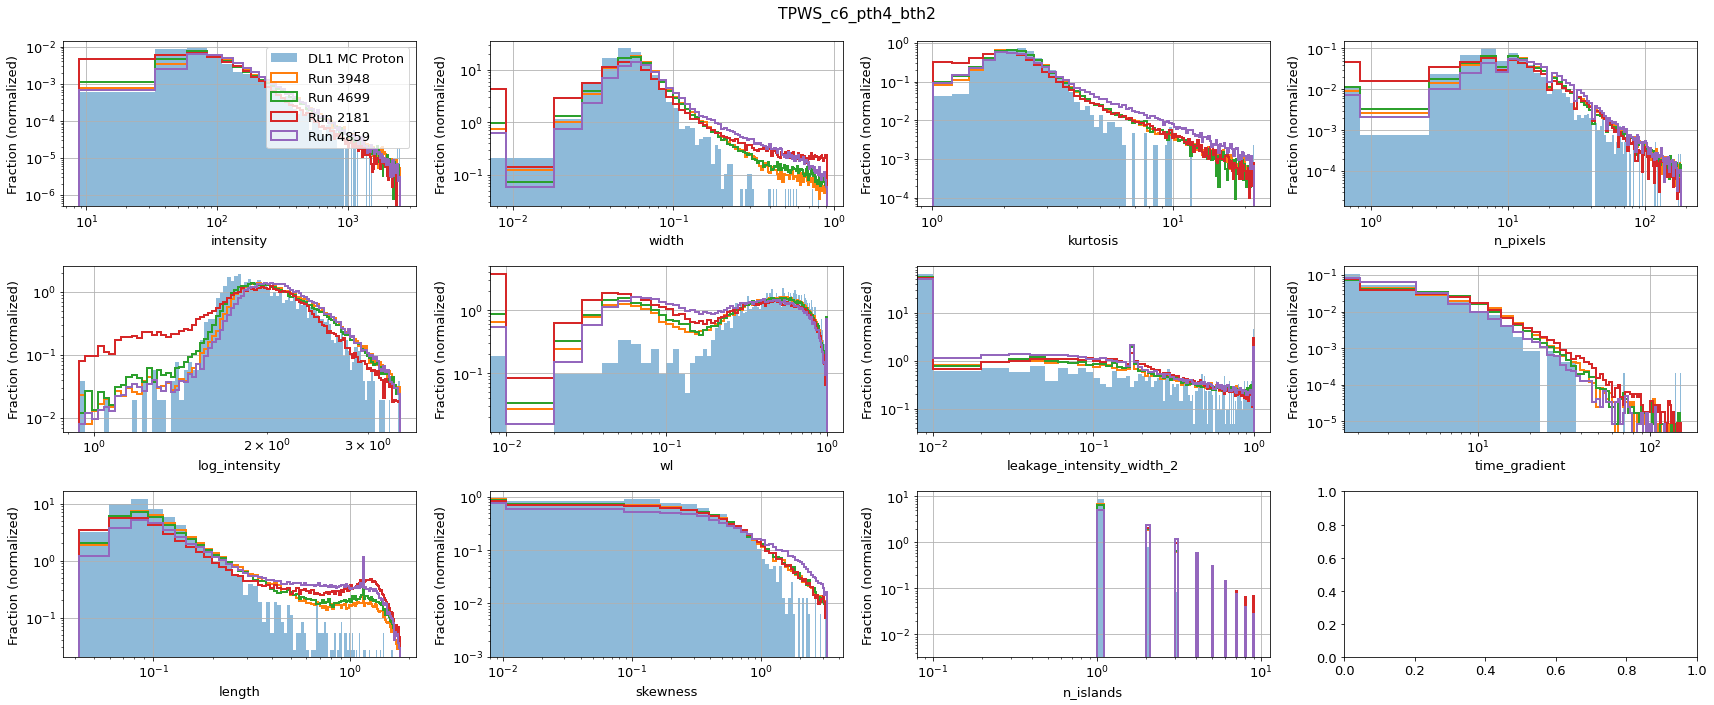

In [44]:
plots = []
NCOLS = 3
NROWS = ceil(len(HILLASES_OF_INTEREST)/NCOLS)
for j, (lowlevel_config, real_lowlevel_config) in enumerate(zip(lowlevel_configs, real_lowlevel_configs)):
#for j, lowlevel_config in enumerate(lowlevel_configs):
    #plot.append(plt.subplots(len(lowlevel_configs), len(HILLASES_OF_INTEREST), figsize=(10,6**len(HILLASES_OF_INTEREST))))#(6*len(lowlevel_configs), 6*len(HILLASES_OF_INTEREST))))
    plots.append(plt.subplots(NCOLS, NROWS, figsize=(6*NROWS, 10)))#(6*len(lowlevel_configs), 6*len(HILLASES_OF_INTEREST))))
    fig, axes = plots[-1]
    fig.suptitle(lowlevel_config.abbreviation)
    for i, param in enumerate(HILLASES_OF_INTEREST):
        # MC
        dl1_mc = dl1_data_dict[lowlevel_config] 
        vals_mc = dl1_mc.parameter_value_dict[param]
        hist_results = {}
        if not param in hist_results.keys():
            hist_results[param] = axes[i%NCOLS][int(i/NCOLS)].hist(vals_mc, lw=2, bins=100, histtype="stepfilled", alpha=0.5, label=dl1_mc.name, density=True)
        else:
            axes[i%NCOLS][int(i/NCOLS)].hist(vals_mc, lw=2, bins=hist_results[param][1], histtype="stepfilled", alpha=0.5, label=dl1_mc.name, density=True)
        # Real
        for run in real_runs:
            dl1_data = real_dl1_data_dict[real_lowlevel_config][run]
            mask_trigger = np.array(dl1_data.parameter_value_dict["intensity"])>20000
            vals = ma.masked_array(dl1_data.parameter_value_dict[param], mask=mask_trigger)
            axes[i%NCOLS][int(i/NCOLS)].hist(vals, lw=2, bins=hist_results[param][1], histtype="step", label='Run {0}'.format(run), density=True)
        #title = lowlevel_config.abbreviation
        #axes[int(i/NCOLS)][i%NCOLS].set_title(title)
        axes[i%NCOLS][int(i/NCOLS)].grid(True, which='major', axis='both')
        axes[i%NCOLS][int(i/NCOLS)].set_yscale('log')
        axes[i%NCOLS][int(i/NCOLS)].set_xscale('log')
        #axes[int(i/NCOLS)][i%NCOLS].set_ylim(1e-3, 1)
        #if j==len(lowlevel_configs)-1:
        axes[i%NCOLS][int(i/NCOLS)].set_xlabel(param)
        axes[i%NCOLS][int(i/NCOLS)].set_ylabel('Fraction (normalized)')
        if i==0:
            axes[i%NCOLS][int(i/NCOLS)].legend(loc=0)    
    plt.tight_layout() 

75/2140
75/2140
75/2140


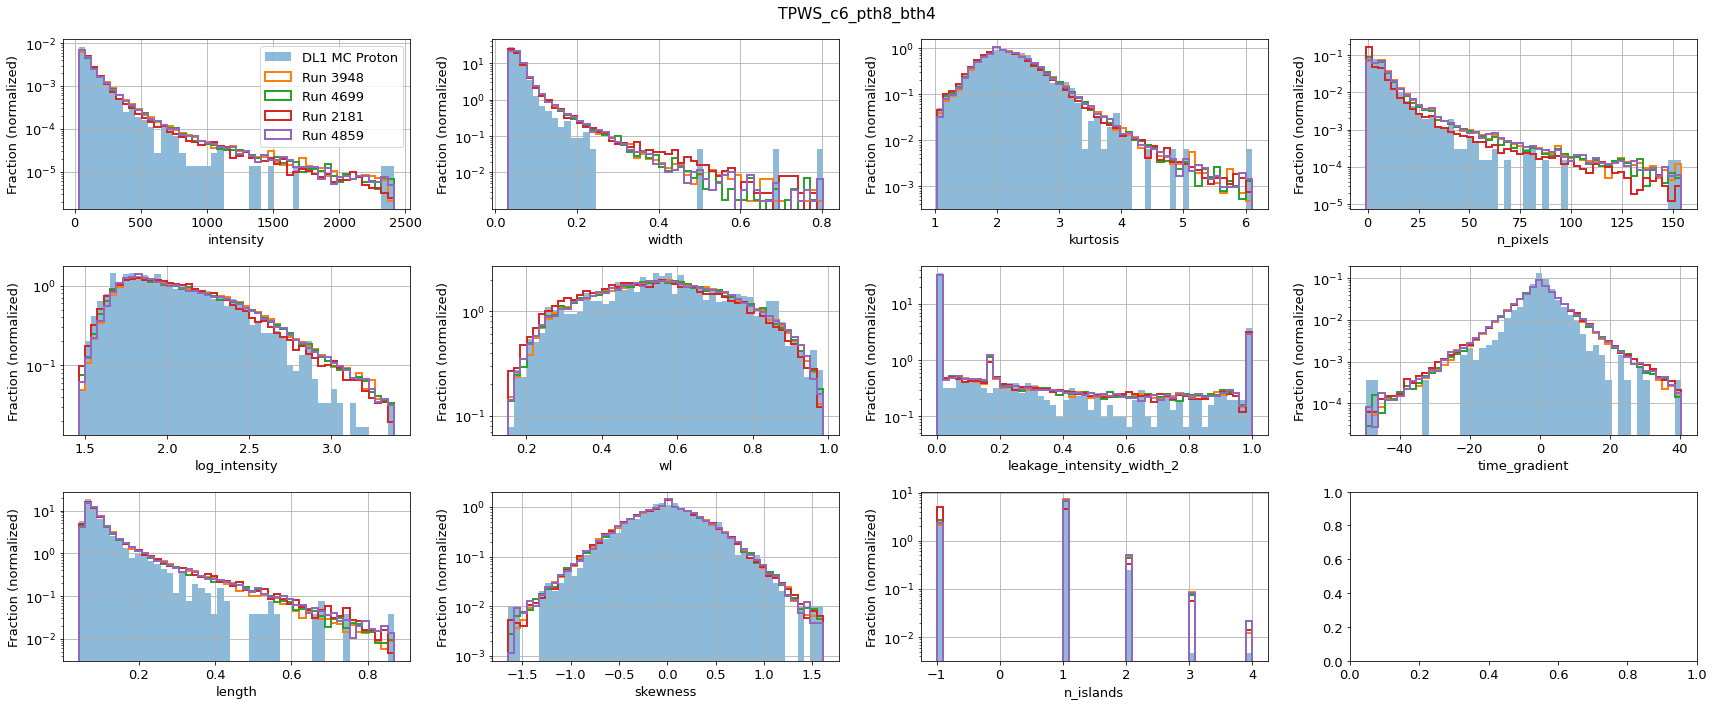

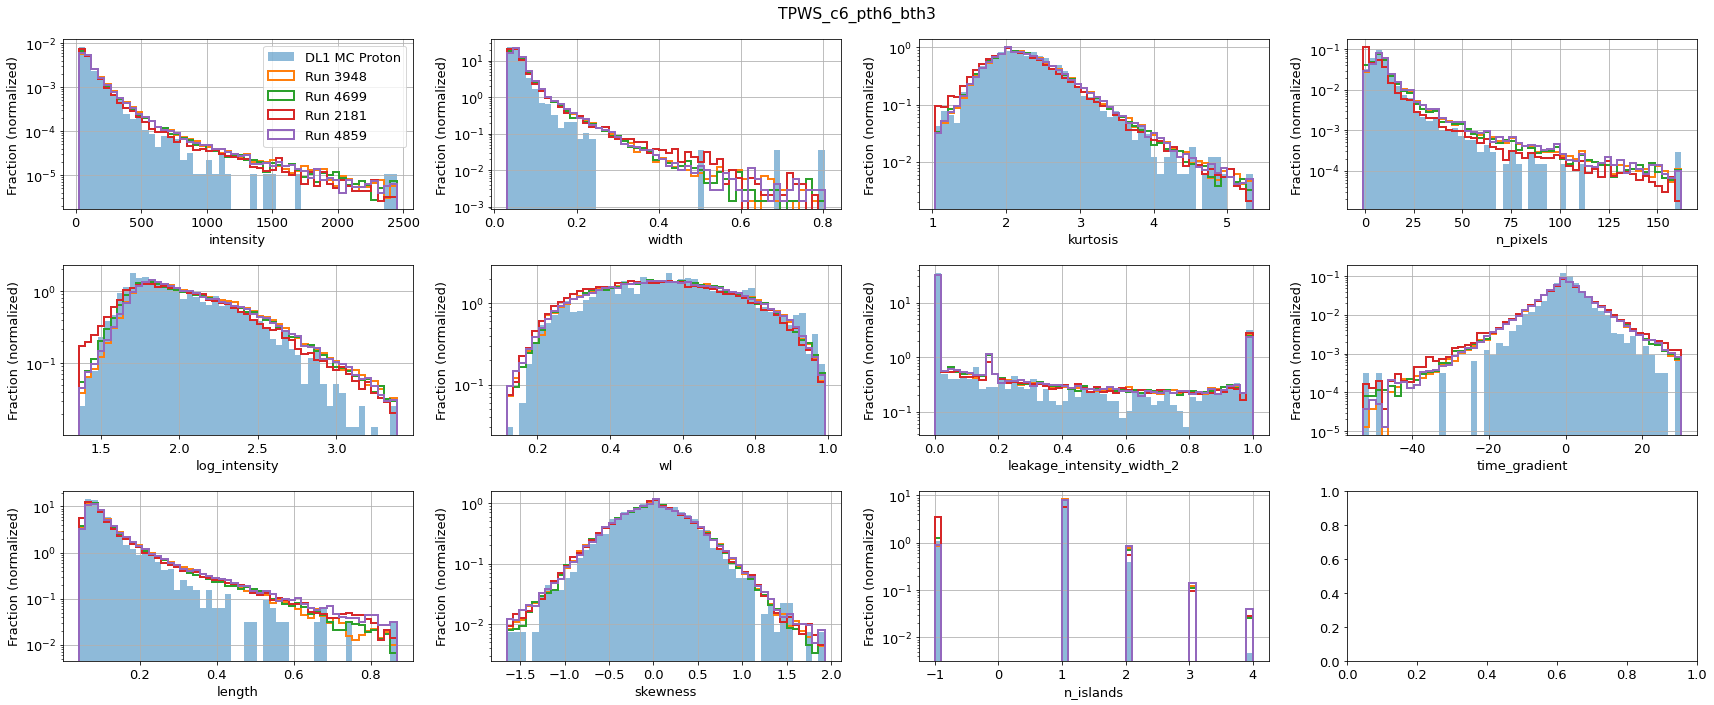

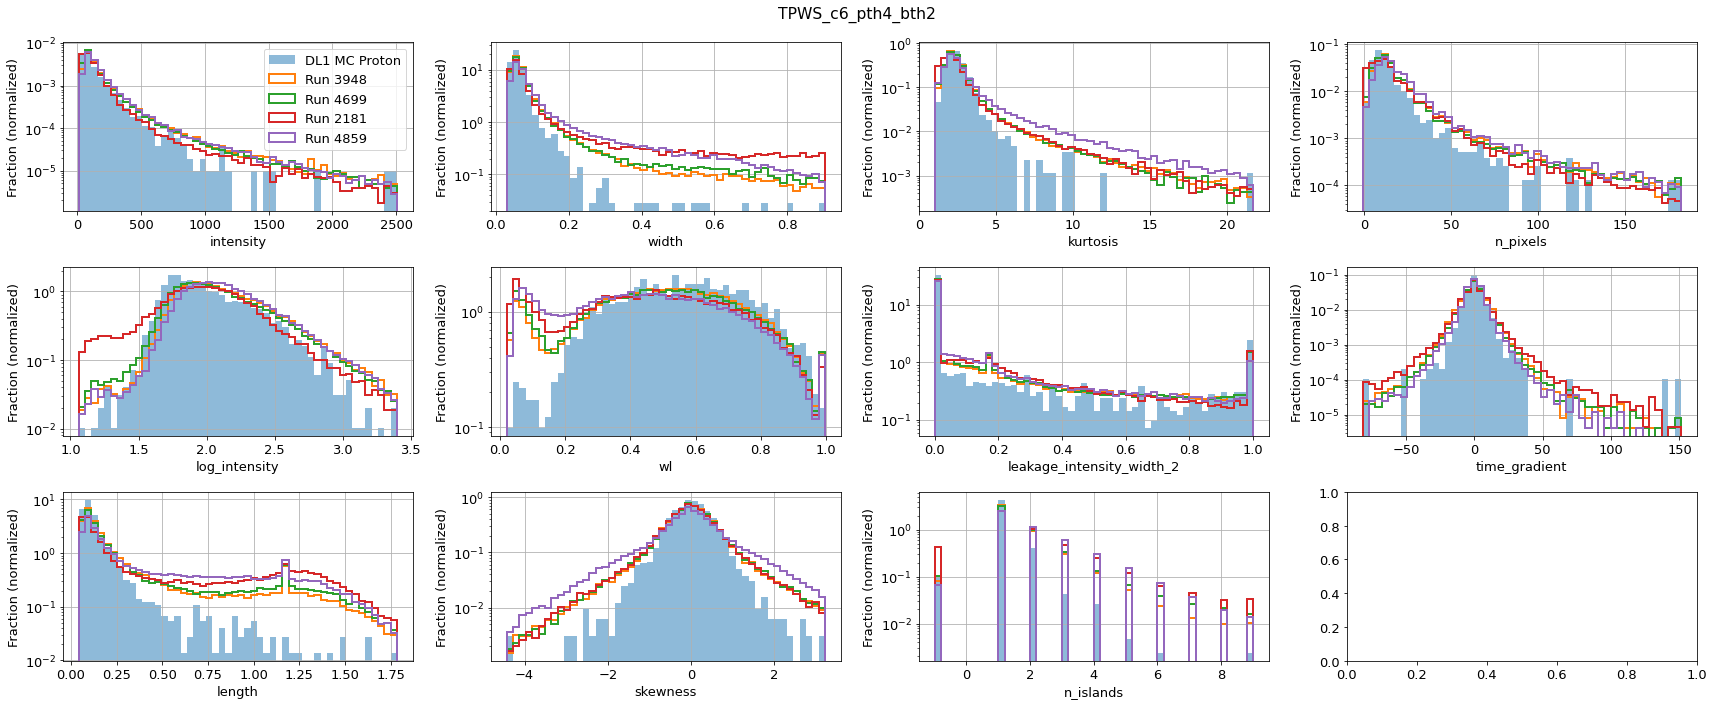

In [46]:
# Intensity cut
INTENSITY_MAX = 100000
INTENSITY_MIN = 0
# Width cut
WIDTH_MAX = 0.03

plots = []
NCOLS = 3
NROWS = ceil(len(HILLASES_OF_INTEREST)/NCOLS)
for j, (lowlevel_config, real_lowlevel_config) in enumerate(zip(lowlevel_configs, real_lowlevel_configs)):
#for j, lowlevel_config in enumerate(lowlevel_configs):
    #plot.append(plt.subplots(len(lowlevel_configs), len(HILLASES_OF_INTEREST), figsize=(10,6**len(HILLASES_OF_INTEREST))))#(6*len(lowlevel_configs), 6*len(HILLASES_OF_INTEREST))))
    plots.append(plt.subplots(NCOLS, NROWS, figsize=(6*NROWS, 10)))#(6*len(lowlevel_configs), 6*len(HILLASES_OF_INTEREST))))
    fig, axes = plots[-1]
    fig.suptitle(lowlevel_config.abbreviation)
    dl1_mc = dl1_data_dict[lowlevel_config] 
    
    #mask_trigger_mc = (np.array(dl1_mc.parameter_value_dict["intensity"])<INTENSITY_MIN) \
    #                + (np.array(dl1_mc.parameter_value_dict["intensity"])>INTENSITY_MAX)

    # Mask MC events
    mcevent_masks = {}
    mcevent_masks["intensity>{imax}".format(imax=INTENSITY_MAX)] = np.array(dl1_mc.parameter_value_dict["intensity"])>INTENSITY_MAX
    mcevent_masks["width<={wmin}".format(wmin=WIDTH_MAX)] = np.array(dl1_mc.parameter_value_dict["width"])<=WIDTH_MAX            
    mcmask_sum = np.zeros_like(dl1_mc.parameter_value_dict["intensity"])
    for mask_array in mcevent_masks.values():
        mcmask_sum += mask_array
        
    # Mask real events
    dl1_data = {}
    mask_sum = {}
    for run in real_runs:
        dl1_data[run] = real_dl1_data_dict[real_lowlevel_config][run]         
        event_masks = {}
        for mask_key in [EventType.FLATFIELD, EventType.SKY_PEDESTAL]:
            event_masks[mask_key] = np.array(dl1_data[run].parameter_value_dict["event_type"])==mask_key.value
        event_masks["intensity>{imax}".format(imax=INTENSITY_MAX)] = np.array(dl1_data[run].parameter_value_dict["intensity"])>INTENSITY_MAX
        event_masks["width<={wmin}".format(wmin=WIDTH_MAX)] = np.array(dl1_data[run].parameter_value_dict["width"])<=WIDTH_MAX            
        mask_sum[run] = np.zeros_like(dl1_data[run].parameter_value_dict["event_type"])
        for mask_array in event_masks.values():
            mask_sum[run] += mask_array        
                
    logger.warning('{0}/{1}'.format(sum(mask_trigger_mc), len(mask_trigger_mc)))    
    for i, param in enumerate(HILLASES_OF_INTEREST):
        # MC
        vals_mc = ma.masked_array(dl1_mc.parameter_value_dict[param], mask=mcmask_sum)
        hist_results = {}
        if not param in hist_results.keys():
            hist_results[param] = axes[i%NCOLS][int(i/NCOLS)].hist(vals_mc, lw=2, bins=50, histtype="stepfilled", alpha=0.5, label=dl1_mc.name, density=True)
        else:
            axes[i%NCOLS][int(i/NCOLS)].hist(vals_mc, lw=2, bins=hist_results[param][1], histtype="stepfilled", alpha=0.5, label=dl1_mc.name, density=True)
        # Real
        for run in real_runs:
            #dl1_data = real_dl1_data_dict[real_lowlevel_config][run]
            
            #mask_trigger = \
            #(np.array(dl1_data.parameter_value_dict["intensity"])<INTENSITY_MIN) \
            #+ (np.array(dl1_data.parameter_value_dict["intensity"])>INTENSITY_MAX) 
            # Mask events
                
            vals = ma.masked_array(dl1_data[run].parameter_value_dict[param], mask=mask_sum[run])
            axes[i%NCOLS][int(i/NCOLS)].hist(vals, lw=2, bins=hist_results[param][1], histtype="step", label='Run {0}'.format(run), density=True)
        #title = lowlevel_config.abbreviation
        #axes[int(i/NCOLS)][i%NCOLS].set_title(title)
        axes[i%NCOLS][int(i/NCOLS)].grid(True, which='major', axis='both')
        axes[i%NCOLS][int(i/NCOLS)].set_yscale('log')
        #axes[int(i/NCOLS)][i%NCOLS].set_xscale('log')
        #axes[int(i/NCOLS)][i%NCOLS].set_ylim(1e-3, 1)
        #if j==len(lowlevel_configs)-1:
        axes[i%NCOLS][int(i/NCOLS)].set_xlabel(param)
        axes[i%NCOLS][int(i/NCOLS)].set_ylabel('Fraction (normalized)')
        if i==0:
            axes[i%NCOLS][int(i/NCOLS)].legend(loc=0)    
    plt.tight_layout() 
    fig_path = lowlevel_config.product_dir_path / "plots" / (lowlevel_config.name+".png")
    if not fig_path.parent.is_dir():
        os.makedirs(fig_path.parent)
    fig.savefig(fig_path)